In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:80% !important;}</style>'))


In [14]:
import pandas as pd
import subprocess
batch_size = 1
start_point = input("starting point")
DWNLD_PATH = "/home/roberttoyonaga/notebooks/roberttoyonaga/CMUDeepLensNRC/HSTLens/detection_pipeline/full_"+str(start_point)
CSV_PATH="test_csv"


im_info = pd.read_csv(CSV_PATH)

def dwnld(entry): 
    subprocess.check_output(["wget", "-O",DWNLD_PATH+ ".fits" ,
                             "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/"+
                             im_info['obj_name'][entry]+"_drz.fits"]) 
print im_info['obj_name']    
'''download image cutouts based on the file names'''
fails=0
for i in range(batch_size):
    print("dwnlding image " + str(i+start_point))
    try: 
        dwnld(i+start_point)
    except:
        fails+=1
        print("Failed")
print("failed: "+str(fails))

starting point675
0       jdn012010
1       jc9q01020
2       jca9ga020
3       jb6u05010
4       jcc212010
5       jcc206010
6       jcc203010
7       jcc202010
8       jcc228010
9       jcc213010
10      jcc225010
11      jcc223010
12      jcc227010
13      jcc216010
14      jcxx16010
15      jcxx28010
16      jdn011010
17      jdhc01020
18      jdan39010
19      jdb630010
20      jdb654010
21      jdb653010
22      jdn006010
23      jdrwdl010
24      jdn024010
25      jdss02010
26      jdrwc8010
27      jdn022010
28      jdl901020
29      jdrw7v010
          ...    
7332    jbtaa3020
7333    j9ej02020
7334    j9en1j010
7335    j9en0n010
7336    j9e094010
7337    j9ez03030
7338    j9ra0f020
7339    j9op20010
7340    j9q714020
7341    j9qg23010
7342    j9ty06030
7343    j9ty38030
7344    j9ty05030
7345    j9ty07030
7346    j9ra1s020
7347    j9ra0h020
7348    j9ra1e020
7349    j9r912030
7350    j9r797030
7351    j9op50010
7352    jcoz88010
7353    jbgq15020
7354    jd7e13020
7355    jd

In [1]:
'''Get the pixel coordinates from SE'''
start_point = input("starting point")

PATH = "image_"+str(start_point)+".cat"
count=0
xl = []
yl =[]

f = open(PATH,'r')
while (True):
    try:
        text = f.readline()
        if count>16:
            words = text.split()
            xl.append(words[1])
            yl.append(words[2])
    except:
        break #breakout once the end is reached
    count+=1

print (xl, yl)

starting point 77


['456.8953', '994.2538', '405.0236', '686.1630', '291.2842', '527.4596', '420.0943', '137.5348', '222.1280', '1173.6552', '256.5922', '766.1634', '873.3118', '811.0426', '909.4087', '42.1491', '628.6073', '689.6393', '1261.3806', '1038.1558', '1800.0490', '161.9766', '110.0115', '1370.1748', '169.7812', '567.6152', '3782.2432', '778.4973', '1437.9229', '1158.9443', '880.1302', '1129.0099', '1587.1879', '2415.2026', '341.8766', '138.4893', '3013.3887', '107.7491', '724.3042', '216.4663', '1327.1555', '2678.3535', '423.2005', '1405.1708', '232.9878', '881.5562', '841.6067', '979.1960', '1019.9857', '1351.4706', '1049.5642', '2022.0424', '1518.4838', '769.8198', '3850.3435', '503.3613', '2105.1733', '1216.9854', '1976.9681', '1333.8270', '1325.1377', '2161.8679', '1445.7502', '648.0129', '3430.7471', '1244.8632', '2410.2546', '2148.6462', '2692.9084', '808.1507', '997.8683', '1737.6588', '2093.9424', '1366.0244', '2544.9219', '1103.6663', '1427.5920', '2305.6414', '583.8510', '1770.5909',

## 

In [2]:
'''Get the ra/dec and make cutouts'''
'''for each detected obj in the large image, make a cutout and calculate/store the ra/dec'''
from astropy.io import fits
import astropy.wcs as wcs
import numpy as np
from astropy.nddata.utils import Cutout2D
from sklearn.preprocessing import minmax_scale
import time
import tensorflow
import keras
from keras.layers import Activation
from keras.layers import Conv2D, ELU
from HSTLens_resnet2 import deeplens_classifier
import pandas as pd
width=100
IMAGE_PATH = 'full_'+str(start_point)


crd_dict = {'ra': [], 'dec': []}
ims = np.zeros((len(xl),1, width, width))
data, hdr = fits.getdata(IMAGE_PATH + ".fits", 0, header=True) #load image into memory only once  (18s vs. 0.28s)
data = np.nan_to_num(data)
w = wcs.WCS(hdr)

'''for each detected obj in the large image, make a cutout and calculate/store the ra/dec'''
bad_images = []
c_sig=10
for cutout in range(len(xl)):
    try:

        worldcrd = w.all_pix2world(float(xl[cutout]), float(yl[cutout]),1) #1 for fits
        crd_dict['ra'].append(float(worldcrd[0]))
        crd_dict['dec'].append(float(worldcrd[1]))
        centered_cut = Cutout2D(data,(float(xl[cutout]), 
                                      float(yl[cutout])), (width, width)).data # +random.randint(-15,15)
        
        if centered_cut.shape != (100, 100):
            result = np.zeros((100,100))
            result[:centered_cut.shape[0],:centered_cut.shape[1]] = centered_cut
            centered_cut = result
        
        #normalize
        c = np.nan_to_num(centered_cut)
        sky_c =3.*np.median(centered_cut)- 2.*np.mean(centered_cut) #calc sky
        sigma_c= np.std(c)          #calc sigma
        c[np.isnan(c)]=sky_c          #get rid of NAn
        c[c>(sky_c+c_sig*sigma_c)]=sky_c+c_sig*sigma_c    #clip values
        c= c-sky_c                                         #subtract sky
        tmp_lens2 = c.reshape(-1,)                        #scale 
        tmp_lens2 = minmax_scale(tmp_lens2, feature_range = (0,1))
        centered_cut = tmp_lens2.reshape(centered_cut.shape[1],centered_cut.shape[1])
        
        summed = centered_cut
        np.random.seed()
        h1 = (sky_c)*np.random.randn(10000)
        np.random.shuffle(h1)
        summed = np.add(summed,h1.reshape(100,100)) # you can add constants too
        tmp_image = summed.reshape(-1,)
        tmp_image = minmax_scale(tmp_image, feature_range = (0,1))
        summed = tmp_image.reshape(summed.shape[0],summed.shape[1])

        ims[cutout][0] = summed
    
    except:
        print("skipped due to non-existent image, or conversion error")
        bad_images.append(cutout)
              
ims = np.delete(ims,bad_images, axis=0)
   
    

Using TensorFlow backend.


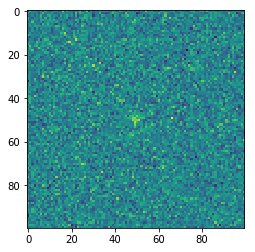

In [5]:
import matplotlib.pyplot as plt
plt.imshow(ims[33][0])

In [8]:
#for testing on the simulated lens components only

import os
from astropy.io import fits
import numpy as np
from sklearn.preprocessing import minmax_scale
import random
POS_PATH = "/home/toyonaga/projects/def-sfabbro/toyonaga/HSTLens/CC_batch_processing/real_lenses/"
set_size =40  #includes both pos and neg samples

ims = np.ones((set_size, 1, 100, 100))
 
#load the positives into odd numered indices
c_sig=10
count =0
for filename in os.listdir(POS_PATH):
    if filename.endswith(".fits") and count<set_size: 
        pic = fits.open(POS_PATH+filename)[0].data
    
        #normalize
        c = np.nan_to_num(pic)
        sky_c =3.*np.median(pic)- 2.*np.mean(pic) #calc sky
        sigma_c= np.std(c)          #calc sigma
        c[np.isnan(c)]=sky_c          #get rid of NAn
        c[c>(sky_c+c_sig*sigma_c)]=sky_c+c_sig*sigma_c    #clip values
        c= c-sky_c                                         #subtract sky
        tmp_lens2 = c.reshape(-1,)                        #scale 
        tmp_lens2 = minmax_scale(tmp_lens2, feature_range = (0,1))
        pic = tmp_lens2.reshape(pic.shape[1],pic.shape[1])

        summed = pic
        np.random.seed()
        h1 = (sky_c)*np.random.randn(10000)
        np.random.shuffle(h1)
        summed = np.add(summed,h1.reshape(100,100)) # you can add constants too
        tmp_image = summed.reshape(-1,)
        tmp_image = minmax_scale(tmp_image, feature_range = (0,1))
        summed = tmp_image.reshape(summed.shape[0],summed.shape[1])

        ims[count][0] = summed  
        
        count+=1
        

          
            

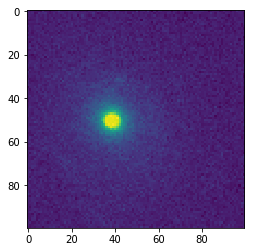

In [44]:
import matplotlib.pyplot as plt
plt.imshow(ims[39][0])

(330, 330)


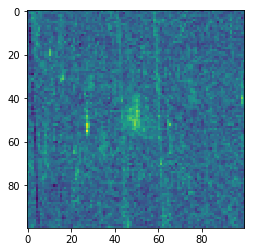

In [278]:
#using this mssing things up. Always get 20 lenses detected

alt_ims = np.nan_to_num(ims)
bad_images = []
for i in range(len(alt_ims)):
    if np.median( alt_ims[i][0]) ==0:
        bad_images.append(i)
alt_ims = np.delete(alt_ims,bad_images, axis=0)
print (len(ims), len(alt_ims) )
plt.imshow(alt_ims[4][0])

In [2]:
import tensorflow
import keras
from keras.layers import Activation
from keras.layers import Conv2D, ELU
from HSTLens_resnet2 import deeplens_classifier
import pandas as pd
'''Feed cutouts to model and make CSV with lens ra/dec'''
OUT_PATH= "resultssss"+str(2)+".out"

'''Feed cutouts to model and make CSV with lens ra/dec'''

my_model = deeplens_classifier()
my_model._build() #should not accept arguments
my_model.model.load_weights("combined_nonsubtracted_weights_resnet2_h2_55000")


Using TensorFlow backend.


building resnet10_CC
(?, 1, 100, 100)
pre- resnet block entered!
relu 2 conv, 
kernel= 3
shorcut (?, 32, 50, 50) net (?, 32, 50, 50)
pre- resnet block entered!
relu 2 conv, 
kernel= 3
shorcut (?, 64, 25, 25) net (?, 64, 25, 25)
pre- resnet block entered!
relu 2 conv, 
kernel= 3
shorcut (?, 128, 12, 12) net (?, 128, 12, 12)


In [ ]:
##### '''Feed cutouts to model and make CSV with lens ra/dec'''
import tensorflow
import keras
from keras.layers import Activation
from keras.layers import Conv2D, ELU
from HSTLens_resnet2 import deeplens_classifier
import pandas as pd
'''Feed cutouts to model and make CSV with lens ra/dec'''
OUT_PATH= "resultssss"+str(2)+".out"

'''Feed cutouts to model and make CSV with lens ra/dec'''

my_model = deeplens_classifier()
my_model._build() #should not accept arguments
my_model.model.load_weights("combined_nonsubtracted_weights_resnet2_h2_55000")
predictions  = my_model._predict( ims, y= None, discrete = False)
#predictions =[[0.0],[1.0],[0.0]] #for testing        


print(len(predictions))        
out = pd.DataFrame(crd_dict)
lens = []
neg= []
for prediction in range(len(predictions)):
    if (predictions[prediction] >0.9):
        lens.append(prediction)
        out['prb'][prediction] = predictions[prediction] 
    else:
        neg.append(prediction)
out = out.drop(out.index[neg]) #drop all the rows that are not lenses
out.to_csv(OUT_PATH, index = False) #dont save the indexing


    


building resnet10_CC
(?, 1, 100, 100)
pre- resnet block entered!
relu 2 conv, 
kernel= 3
shorcut (?, 32, 50, 50) net (?, 32, 50, 50)
pre- resnet block entered!
relu 2 conv, 
kernel= 3
shorcut (?, 64, 25, 25) net (?, 64, 25, 25)
pre- resnet block entered!
relu 2 conv, 
kernel= 3
shorcut (?, 128, 12, 12) net (?, 128, 12, 12)


In [1]:
out

NameError: name 'out' is not defined

110


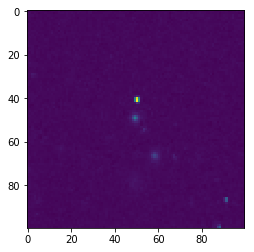

curr num 23next=1, exit=00


In [39]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from IPython import display

import os

#i=99
sp=int(input("start position"))
for i in range(len(lens)):
    exit=False
    display.clear_output(wait=True)
    plt.imshow(ims[lens[i+sp]][0]) 
    print(lens[i+sp])
    plt.pause(0.01)

    while(1):
        ans = input("curr num "+str(i+sp)+"next=1, exit=0")
        plt.show()

        if ans ==1:
            break
        if ans ==0:
            exit=True
            break
    if exit==True:
        break

# 

In [50]:
#decision threshold
count =0
for i in alt:
    if i>0.95:
        count+=1
count, float(count)/len(predictions)

(207, 0.07829046898638427)

((array([2040.,   42.,   28.,   23.,   20.,   13.,    9.,    7.,   15.,
            9.,    6.,   18.,   14.,   17.,   15.,   16.,    6.,   11.,
            9.,    7.,   15.,    8.,    9.,   12.,    8.,   12.,   20.,
           16.,   26.,  193.]),
  array([0.        , 0.03333334, 0.06666667, 0.1       , 0.13333334,
         0.16666667, 0.2       , 0.23333333, 0.26666668, 0.3       ,
         0.33333334, 0.36666667, 0.4       , 0.43333334, 0.46666667,
         0.5       , 0.53333336, 0.56666666, 0.6       , 0.6333333 ,
         0.6666667 , 0.7       , 0.73333335, 0.76666665, 0.8       ,
         0.8333333 , 0.8666667 , 0.9       , 0.93333334, 0.96666664,
         1.        ], dtype=float32),
  <a list of 30 Patch objects>),
 2644)

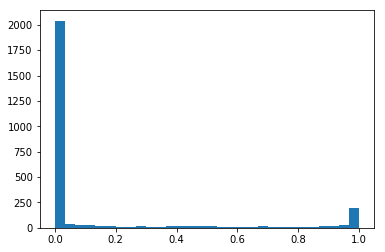

In [42]:
alt = np.nan_to_num(predictions)

plt.hist(alt,30), len(alt)


In [35]:

with open ('ff.txt', "w+") as f:
    f.write (raw_input ());

sdaf


In [229]:
import matplotlib.pyplot as plt


from IPython import display

import os
print ims.shape
ims=ims
sp=int(input("start position"))
for i in range(len(ims)):
    exit=False
    display.clear_output(wait=True)
    plt.imshow(ims[i+sp][0]) 
    plt.pause(0.01)

    while(1):
        ans = input("curr num "+str(i+sp)+"next=1, exit=0")
        plt.show()

        if ans ==1:
            break
        if ans ==0:
            exit=True
            break
    if exit==True:
        break

3000

# 42, 91